In [1]:
import numpy as np
from numba import jit
from scipy import ndimage
from osgeo import gdal, osr, ogr
import matplotlib.pyplot as plt

plt.style.use('default')

In [2]:
@jit(nopython=True)
def np_mean(neighborhood):
    return np.nanmean(neighborhood)

In [3]:
def lonlat_to_utm(lon, lat):
    if lat < 0:
        return int(32700 + np.floor((180+lon)/6) + 1)
    else:
        return int(32600 + np.floor((180+lon)/6) + 1)

In [4]:
def generate_contours(dem_band, dem_nodata, iterval=50):
    contours = ogr.GetDriverByName('Memory').CreateDataSource('')
    contours_lyr = contours.CreateLayer('contour', 
                                        geom_type=ogr.wkbLineString25D, 
                                        srs=srs)
    field_defn = ogr.FieldDefn('ID', ogr.OFTInteger)
    contours_lyr.CreateField(field_defn)
    field_defn = ogr.FieldDefn('elev', ogr.OFTReal)
    contours_lyr.CreateField(field_defn)

    # Generate the smoothed Contours
    gdal.ContourGenerate(dem_band, iterval, 0, [], 1, 
                         dem_nodata, contours_lyr, 0, 1)
    features = []
    for fc in contours_lyr:
        features.append(fc)
    return features
    

In [5]:
in_dem = r"..\Data\N46E009.hgt"
dem_ds = gdal.Open(in_dem)
prj = dem_ds.GetProjection()
srs = osr.SpatialReference(wkt=prj)

gt = dem_ds.GetGeoTransform()
xmin, xpixel, _, ymax, _, ypixel = gt

# Project to UTM zone
utm_epsg = lonlat_to_utm(xmin, ymax)
dem_ds = gdal.Warp("", dem_ds, format="MEM", dstSRS=f'EPSG:{utm_epsg}')

# Get SRS
prj = dem_ds.GetProjection()
srs = osr.SpatialReference(wkt=prj)

# Get the new gt
gt = dem_ds.GetGeoTransform()
xmin, xpixel, _, ymax, _, ypixel = gt
dem_band = dem_ds.GetRasterBand(1)
dem_nodata = dem_band.GetNoDataValue()
width, height = dem_ds.RasterXSize, dem_ds.RasterYSize
xmax = xmin + width * xpixel
ymin = ymax + height * ypixel

# Get the array
dem_array = dem_band.ReadAsArray().astype(float)
dem_array[dem_array == dem_nodata] = np.nan

In [6]:
# Apply a local filter where the resulting value is the mean of the neighborhood 
kernel_size = 9
filtered_dem = ndimage.generic_filter(dem_array, 
                                      np_mean, 
                                      size=kernel_size, 
                                      cval=np.nan)

In [ ]:
# Create a layer from the filtered_dem
srs = osr.SpatialReference()
srs.ImportFromWkt(prj)
filtered_dem[np.isnan(filtered_dem)] = dem_nodata
driver = gdal.GetDriverByName("MEM")
filtered_dem_ds = driver.Create("", width, height, 1, gdal.GDT_Float32)
filtered_dem_ds.GetRasterBand(1).WriteArray(filtered_dem)
filtered_dem_ds.GetRasterBand(1).SetNoDataValue(dem_nodata)
filtered_dem_ds.SetGeoTransform(gt)
filtered_dem_ds.SetProjection(srs.ExportToWkt())

0

In [ ]:
# Create a layer for non-smoothed contours
contours_nogen = generate_contours(dem_ds.GetRasterBand(1), dem_nodata)

In [ ]:
# Create a layer for smoothed contours
contours_gen = generate_contours(filtered_dem_ds.GetRasterBand(1), dem_nodata)

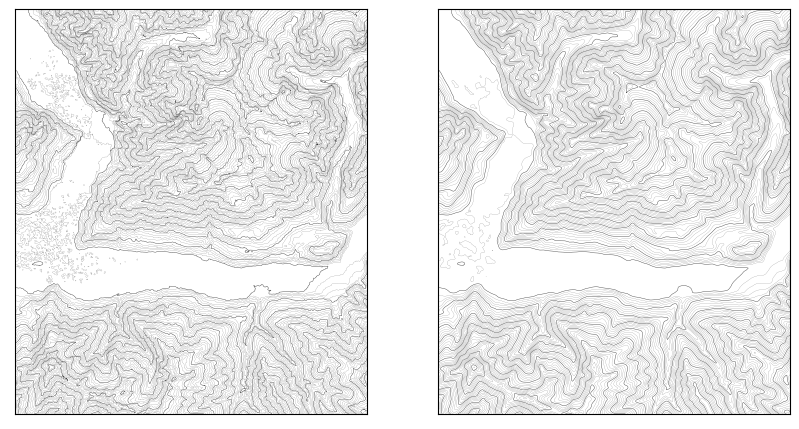

In [ ]:
# Plot the contours
xlim_min, xlim_max = 530000, 550000
ylim_min, ylim_max = 5102000, 5125000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

# Plot non-smoothed contours
for fc in contours_nogen:
    geom = fc.GetGeometryRef()
    elev = fc.GetField("elev")
    pts = np.array([(pt[0], pt[1]) for pt in geom.GetPoints()])
    if elev % 250 == 0:
        lw = 0.3
    else:
        lw = 0.1
    ax1.plot(pts[:, 0], pts[:, 1], lw=lw, c=(0,0,0, 0.75))

# Plot smoothed contours
for fc in contours_gen:
    geom = fc.GetGeometryRef()
    elev = fc.GetField("elev")
    pts = np.array([(pt[0], pt[1]) for pt in geom.GetPoints()])
    if elev % 250 == 0:
        lw = 0.3
    else:
        lw = 0.1
    ax2.plot(pts[:, 0], pts[:, 1], lw=lw, c=(0, 0, 0, 0.75))

ax1.set_xlim(xlim_min, xlim_max)
ax1.set_ylim(ylim_min, ylim_max)
ax1.set_aspect(True)
ax2.set_xlim(xlim_min, xlim_max)
ax2.set_ylim(ylim_min, ylim_max)
ax2.set_aspect(True)
plt.savefig("contours_gdal.jpg", 
            dpi=300, 
            bbox_inches="tight")
plt.show()